# Import libaries

In [1]:
import pandas as pd
from pylab import *
import seaborn as sns
sns.set(style="whitegrid")
import csv
import gc
import scipy
from scipy.stats.stats import pearsonr, spearmanr
import time
from tqdm import *
import statsmodels.formula.api as smf
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'power', '__version__', 'info', 'linalg', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Define import and export paths

In [2]:
import_path = '/Users/g.triulzi/Dropbox (MIT)/Paper Predicting K with Patents/Data/Input/'
export_path = '/Users/g.triulzi/Dropbox (MIT)/Paper Predicting K with Patents/Data/Output/'

# Import and manipulate data

In [3]:
PATENT_SET_DOMAINS = pd.read_csv(import_path+'Domains_patent_info.csv')

In [3]:
ti =time.time()
# load assignee disambiguated IDs and clean names
ASSIGNEE = (pd.read_csv('/Users/g.triulzi/Dropbox (MIT)/USPTO Database 2015/assignee.tsv', 
                        sep='\t', header=0,encoding='ISO-8859-1'))
RAW_ASSIGNEE = (pd.read_csv('/Users/g.triulzi/Dropbox (MIT)/USPTO Database 2015/rawassignee.tsv', 
                            sep='\t', header=0,encoding='ISO-8859-1'))
ASSIGNEE.rename(columns={"id":"assignee_id"},inplace=True)
RAW_ASSIGNEE.rename(columns={"patent_id":"patent_number"},inplace=True)

RAW_ASSIGNEE=(pd.merge(RAW_ASSIGNEE[['patent_number','assignee_id','sequence']],
                       ASSIGNEE[['assignee_id','type','organization']], 
                             how = 'left', left_on = ['assignee_id'], right_on = ['assignee_id']))

idx_letters = (RAW_ASSIGNEE['patent_number'].astype(str)
               .str.contains('a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z|/|;|-|nan', na=False, case=False))
RAW_ASSIGNEE = RAW_ASSIGNEE[~idx_letters]

del ASSIGNEE
gc.collect()

RAW_ASSIGNEE['patent_number'] = RAW_ASSIGNEE['patent_number'].astype(int)
PATENT_SET_DOMAINS=(pd.merge(PATENT_SET_DOMAINS,
                             RAW_ASSIGNEE[['patent_number','assignee_id','organization']][RAW_ASSIGNEE['sequence']==0],
                             how = 'left', left_on = ['patent_number'], right_on = ['patent_number']))
del RAW_ASSIGNEE
gc.collect()

tf = time.time()
(tf-ti)/60

C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0.4857542395591736

In [6]:
# Read list of observed improvement rates for each domain
PERFORMANCE_DOMAINS = pd.read_csv(import_path+'PERFORMANCE_DOMAINS_K_Kr2.csv')
PERFORMANCE_DOMAINS['log_K']=log(PERFORMANCE_DOMAINS['K'])

# Expected entropy given number of patents (= maximum entropy)

In [5]:
expected_entropy=[]
patcount = list(range(200000))[1:]
for x in patcount:
    e = log(x) #-((x)*(1/x)*(log(1/x))) <-- this simplifies to log(x), as log(1/x)=-log(x)
    expected_entropy.append(e)
MAXIMUM_ENTROPY=pd.DataFrame()
MAXIMUM_ENTROPY['patent_count']=patcount
MAXIMUM_ENTROPY['maximum_entropy']=expected_entropy

In [6]:
DOMAIN_SIZE = (PATENT_SET_DOMAINS[['patent_number','assignee_id','Domain']]
                                .groupby(['Domain']).agg('count').reset_index()
                                .rename(columns={"patent_number":"patent_count","assignee_id":"assignee_count"}))
DOMAIN_SIZE['maximum_entropy_patcount']=array(MAXIMUM_ENTROPY['maximum_entropy'][array(DOMAIN_SIZE['patent_count']-1)])
DOMAIN_SIZE['maximum_entropy_assigneecount']=array(MAXIMUM_ENTROPY['maximum_entropy'][array(DOMAIN_SIZE['assignee_count']-1)])

DOMAIN_SIZE.sort_values('patent_count',ascending=False)

,Domain,patent_count,assignee_count,maximum_entropy_patcount,maximum_entropy_assigneecount
15,IC,149214,146462,11.913137,11.894521
9,ELECTRIC_TELECOM,44797,40386,10.709896,10.606238
29,WIRELESS_TELECOM,39545,38056,10.585195,10.546814
25,SEMICOND_INFO_STORAGE,38887,38083,10.568415,10.547523
23,OPTICAL_TELECOM,36391,34820,10.502077,10.457947
18,MAGNETIC_INFO_STORAGE,33454,32207,10.417927,10.379939
22,OPTICAL_INFO_STORAGE,23418,22557,10.061260,10.023801
5,COMB_ENGINE,19015,16076,9.852983,9.685083
8,ELECTRIC_MOTOR,17811,16143,9.787572,9.689242
2,BATTERIES,16039,15144,9.682779,9.625360


# Compute Entropy for each year

In [7]:
ti = time.time()

# Compute entropy of assignee shares in a domain
#idx = PATENT_SET_DOMAINS['assignee_id'].astype(str)!='nan'
DF_grouped_assignee_patcount = (PATENT_SET_DOMAINS[['patent_number','Domain','filing_year','assignee_id']]
                                .groupby(['Domain','filing_year','assignee_id']).agg('count'))
DF_grouped_assignee_patcount = DF_grouped_assignee_patcount.reset_index()
DF_grouped_assignee_patcount.rename(columns={"patent_number":"assignee_patent_count"},inplace=True)


DF_grouped_domain_patcount = (PATENT_SET_DOMAINS[['patent_number','assignee_id','Domain','filing_year']]
                                .groupby(['Domain','filing_year']).agg('count').reset_index()
                                 .rename(columns={"patent_number":"domain_patent_count","assignee_id":"domain_assignee_count"}))

DF_grouped_assignee_patcount=(pd.merge(DF_grouped_assignee_patcount,
                             DF_grouped_domain_patcount,
                             how = 'left', left_on = ['Domain','filing_year'], right_on = ['Domain','filing_year']))

DF_grouped_assignee_patcount['assignee_patent_share'] = (DF_grouped_assignee_patcount['assignee_patent_count']
                                                         /DF_grouped_assignee_patcount['domain_patent_count'])

DF_grouped_assignee_patcount['entropy_component'] = (DF_grouped_assignee_patcount['assignee_patent_share']
                                                    * log(DF_grouped_assignee_patcount['assignee_patent_share']))

DF_entropy_domain_patents_in_year = (DF_grouped_assignee_patcount[['Domain','filing_year','entropy_component']]
                                     .groupby(['Domain','filing_year']).agg('sum'))
DF_entropy_domain_patents_in_year = DF_entropy_domain_patents_in_year.reset_index()
DF_entropy_domain_patents_in_year.rename(columns={"entropy_component":"entropy_patents_in_year"},inplace=True)

DF_entropy_domain_patents_in_year['entropy_patents_in_year'] = - DF_entropy_domain_patents_in_year['entropy_patents_in_year']

DF_OBSERVED_entropy_domain_patents_in_year = DF_entropy_domain_patents_in_year

#DF_entropy_domain_patents_in_year.groupby('Domain').plot(x='filing_year', y='entropy_patents_in_year')

tf = time.time()
(tf-ti)/60

0.005552240212758382

In [8]:
DF_OBSERVED_entropy_domain_patents_in_year=(pd.merge(DF_OBSERVED_entropy_domain_patents_in_year,
                             DF_grouped_domain_patcount,
                             how = 'left', left_on = ['Domain','filing_year'], right_on = ['Domain','filing_year']))

DF_OBSERVED_entropy_domain_patents_in_year['maximum_entropy_patcount']=(array(MAXIMUM_ENTROPY['maximum_entropy']
                                                                     [array(DF_OBSERVED_entropy_domain_patents_in_year
                                                                            ['domain_patent_count']-1)]))

DF_OBSERVED_entropy_domain_patents_in_year['maximum_entropy_assigneecount']=(array(MAXIMUM_ENTROPY['maximum_entropy']
                                                                     [array(DF_OBSERVED_entropy_domain_patents_in_year
                                                                            ['domain_assignee_count']-1)]))

DF_OBSERVED_entropy_domain_patents_in_year['normalized_entropy_patcount']=(DF_OBSERVED_entropy_domain_patents_in_year['entropy_patents_in_year']
                                                                 /DF_OBSERVED_entropy_domain_patents_in_year['maximum_entropy_patcount'])

DF_OBSERVED_entropy_domain_patents_in_year['normalized_entropy_assigneecount']=(DF_OBSERVED_entropy_domain_patents_in_year['entropy_patents_in_year']
                                                                 /DF_OBSERVED_entropy_domain_patents_in_year['maximum_entropy_assigneecount'])

(1975, 2015)

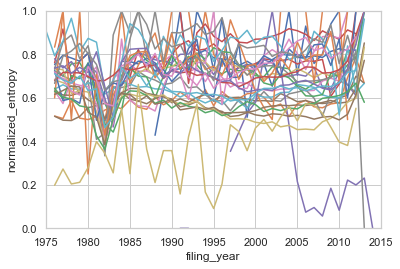

In [9]:
x='filing_year' 
y='normalized_entropy_patcount'

for domain in DF_OBSERVED_entropy_domain_patents_in_year.Domain.unique():
    idx = DF_OBSERVED_entropy_domain_patents_in_year['Domain']==domain
    plot(DF_OBSERVED_entropy_domain_patents_in_year[x][idx], DF_OBSERVED_entropy_domain_patents_in_year[y][idx], label=domain)

xlabel('filing_year')
ylabel('normalized_entropy')

ylim(0,1)
xlim(1975,2015)

Text(0, 0.5, 'normalized_entropy_assigneecount')

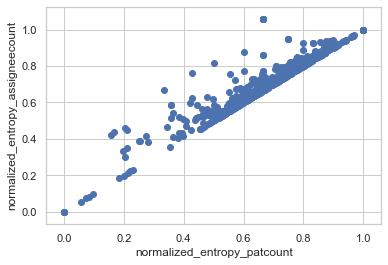

In [10]:
x='normalized_entropy_patcount' 
y='normalized_entropy_assigneecount'

scatter(DF_OBSERVED_entropy_domain_patents_in_year[x], DF_OBSERVED_entropy_domain_patents_in_year[y], label=domain)

xlabel('normalized_entropy_patcount')
ylabel('normalized_entropy_assigneecount')

In [11]:
x='normalized_entropy_patcount' 
y='normalized_entropy_assigneecount'
idx = ((DF_OBSERVED_entropy_domain_patents_in_year[x].astype(str)!='nan') 
       & (DF_OBSERVED_entropy_domain_patents_in_year[y].astype(str)!='nan')
      & (DF_OBSERVED_entropy_domain_patents_in_year[x].astype(str)!='inf')
      & (DF_OBSERVED_entropy_domain_patents_in_year[y].astype(str)!='inf'))
pearsonr(DF_OBSERVED_entropy_domain_patents_in_year[x][idx], DF_OBSERVED_entropy_domain_patents_in_year[y][idx])


(0.9526750781243806, 0.0)

# Compute Entropy up to each year

In [12]:
DF_OBSERVED_entropy_domain_patents_up_to_year = pd.DataFrame()

for year in tqdm(range(1975,2016)):
    DATA = PATENT_SET_DOMAINS[PATENT_SET_DOMAINS['filing_year']<=year]
    
    # Compute entropy of assignee shares in a domain
    idx = DATA['assignee_id'].astype(str)!='nan'
    DF_grouped_assignee_patcount = (DATA[['patent_number','Domain','assignee_id']][idx]
                                    .groupby(['Domain','assignee_id']).agg('count'))
    DF_grouped_assignee_patcount = DF_grouped_assignee_patcount.reset_index()
    DF_grouped_assignee_patcount.rename(columns={"patent_number":"assignee_patent_count"},inplace=True)


    DF_grouped_domain_patcount = (DATA[['patent_number','Domain']]
                                    .groupby(['Domain']).agg('count'))
    DF_grouped_domain_patcount = DF_grouped_domain_patcount.reset_index()
    DF_grouped_domain_patcount.rename(columns={"patent_number":"domain_patent_count"},inplace=True)

    
    DF_grouped_assignee_patcount=(pd.merge(DF_grouped_assignee_patcount,
                                 DF_grouped_domain_patcount,
                                 how = 'left', left_on = ['Domain'], right_on = ['Domain']))

    DF_grouped_assignee_patcount['assignee_patent_share'] = (DF_grouped_assignee_patcount['assignee_patent_count']
                                                             /DF_grouped_assignee_patcount['domain_patent_count'])

    DF_grouped_assignee_patcount['entropy_component'] = (DF_grouped_assignee_patcount['assignee_patent_share']
                                                        * log(DF_grouped_assignee_patcount['assignee_patent_share']))

    DF_entropy_domain_patents_in_year = (DF_grouped_assignee_patcount[['Domain','entropy_component']]
                                         .groupby(['Domain']).agg('sum'))
    DF_entropy_domain_patents_in_year = DF_entropy_domain_patents_in_year.reset_index()
    DF_entropy_domain_patents_in_year.rename(columns={"entropy_component":"entropy_patents_up_to_year"},inplace=True)

    DF_entropy_domain_patents_in_year['entropy_patents_up_to_year'] = - DF_entropy_domain_patents_in_year['entropy_patents_up_to_year']
    DF_entropy_domain_patents_in_year['year'] = year
    
    DF_OBSERVED_entropy_domain_patents_up_to_year = DF_OBSERVED_entropy_domain_patents_up_to_year.append(DF_entropy_domain_patents_in_year)

    
idx = PATENT_SET_DOMAINS['assignee_id'].astype(str)!='nan'
DF_grouped_domain_patcount = (PATENT_SET_DOMAINS[['patent_number','Domain','filing_year']][idx]
                                .groupby(['Domain','filing_year']).agg('count'))
DF_grouped_domain_patcount = DF_grouped_domain_patcount.reset_index()
DF_grouped_domain_patcount.rename(columns={"patent_number":"domain_patent_count"},inplace=True)
DF_grouped_domain_patcount['domain_patent_count_cumul'] = (array(DF_grouped_domain_patcount[['Domain','domain_patent_count']]
                                      .groupby('Domain').cumsum()))

DF_OBSERVED_entropy_domain_patents_up_to_year=(pd.merge(DF_OBSERVED_entropy_domain_patents_up_to_year,
                             DF_grouped_domain_patcount,
                             how = 'left', left_on = ['Domain','year'], right_on = ['Domain','filing_year']))

del DF_OBSERVED_entropy_domain_patents_up_to_year['filing_year']

DF_OBSERVED_entropy_domain_patents_up_to_year['maximum_entropy']=(array(MAXIMUM_ENTROPY['maximum_entropy']
                                                                     [array(DF_OBSERVED_entropy_domain_patents_up_to_year
                                                                            ['domain_patent_count_cumul']-1)]))

DF_OBSERVED_entropy_domain_patents_up_to_year['normalized_entropy']=(DF_OBSERVED_entropy_domain_patents_up_to_year['entropy_patents_up_to_year']
                                                                 /DF_OBSERVED_entropy_domain_patents_up_to_year['maximum_entropy'])

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:07<00:00,  5.18it/s]


In [13]:
DF_OBSERVED_entropy_domain_patents_up_to_year_NoNans = pd.DataFrame()
for domain in tqdm(DF_OBSERVED_entropy_domain_patents_up_to_year.Domain.unique()):
    DATA = DF_OBSERVED_entropy_domain_patents_up_to_year[DF_OBSERVED_entropy_domain_patents_up_to_year['Domain']==domain]
    for year in range(1976,2016):
        if array(DATA['domain_patent_count'][DATA['year']==year].astype(str)=='nan'):
            DATA['domain_patent_count'][DATA['year']==year] = 0
            
            last_year_patent_count_cumul = array(DATA['domain_patent_count_cumul'][DATA['year']==year-1])
            DATA['domain_patent_count_cumul'][DATA['year']==year] = last_year_patent_count_cumul
            
            last_year_maximum_entropy = array(DATA['maximum_entropy'][DATA['year']==year-1])
            DATA['maximum_entropy'][DATA['year']==year] = last_year_maximum_entropy
            
            last_year_normalized_entropy = array(DATA['normalized_entropy'][DATA['year']==year-1])
            DATA['normalized_entropy'][DATA['year']==year] = last_year_normalized_entropy
        else: continue
    DF_OBSERVED_entropy_domain_patents_up_to_year_NoNans = DF_OBSERVED_entropy_domain_patents_up_to_year_NoNans.append(DATA)

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

(1975, 2013)

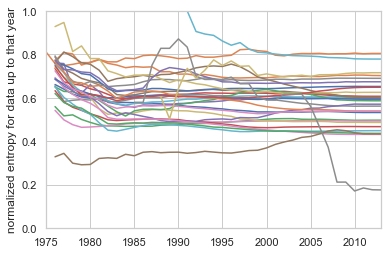

In [14]:
x='year' 
y='normalized_entropy'

for domain in DF_OBSERVED_entropy_domain_patents_up_to_year_NoNans.Domain.unique():
    idx = DF_OBSERVED_entropy_domain_patents_up_to_year_NoNans['Domain']==domain
    plot(DF_OBSERVED_entropy_domain_patents_up_to_year_NoNans[x][idx], DF_OBSERVED_entropy_domain_patents_up_to_year_NoNans[y][idx], label=domain)

#xlabel('filing_year')
ylabel('normalized entropy for data up to that year')

ylim(0,1)
xlim(1975,2013)

#  Correlation with rate of improvement K

In [15]:
PERFORMANCE_DOMAINS = PERFORMANCE_DOMAINS.sort_values('Domain')
DF_domains_over_time = pd.DataFrame()
for year in tqdm(range(1980,2014)):
    DATA = PATENT_SET_DOMAINS[PATENT_SET_DOMAINS['filing_year']<=year]

    SIZE_DOMAIN = DATA[['Domain','patent_number']].groupby('Domain').agg('count')
    SIZE_DOMAIN = SIZE_DOMAIN.reset_index()
    SIZE_DOMAIN.rename(columns={"patent_number": "number_patents_up_to_year"},inplace=True)
    SIZE_DOMAIN['year'] = year
    SIZE_DOMAIN = SIZE_DOMAIN.sort_values('Domain')
    SIZE_DOMAIN = (pd.merge(SIZE_DOMAIN, PERFORMANCE_DOMAINS[['Domain','K','log_K']], 
                             how = 'left', left_on = 'Domain', right_on = 'Domain'))
        
    DF_domains_over_time = DF_domains_over_time.append(SIZE_DOMAIN)

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.30it/s]


In [16]:
#add normalized entropy
DF_domains_over_time=(pd.merge(DF_domains_over_time,
                               DF_OBSERVED_entropy_domain_patents_up_to_year_NoNans[['Domain','year','normalized_entropy']], 
                             how = 'left', left_on = ['Domain','year'], right_on = ['Domain','year']))

In [17]:
DF_stability_prediction_over_time = pd.DataFrame()

for year in tqdm(range(1980,2014)):
    DATA = DF_domains_over_time[(DF_domains_over_time['year']==year) & (DF_domains_over_time['number_patents_up_to_year']>=100)]
    y = 'log_K'
    x1 = 'normalized_entropy'
    correlation_variable_and_K = pearsonr(DATA[x1],DATA[y])[0]
    equation = y + ' ~ ' + x1 #'-1' # this removes the constant
    lm = smf.ols(formula=equation, data=DATA).fit()    
    x='PREDICTED_K'
    DATA[x] = ((lm.params[0] + lm.params[1]*DATA[x1]))
    idx = (~isnan(DATA[y])) & (~isnan(DATA[x]))
    correlation_predicted_observed_K = pearsonr(DATA[x][idx],DATA[y][idx])[0]
    DF = pd.DataFrame({ 'year': year,
                        'correlation_logK_variable' : correlation_variable_and_K,
                        'correlation_logK_predicted_logK':correlation_predicted_observed_K,
                        'intercept':lm.params[0],
                        'coefficient_variable':lm.params[1]},index = [year])
    DF_stability_prediction_over_time = DF_stability_prediction_over_time.append(DF)
    
DF_stability_prediction_over_time['predictor'] = x1

  0%|                                                                                           | 0/34 [00:00<?, ?it/s]C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
100%|█████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 101.17it/s]


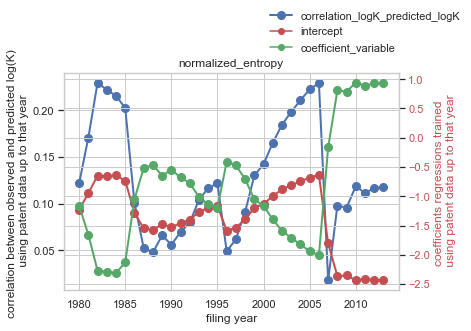

In [18]:
x = 'year'
y1 = 'correlation_logK_predicted_logK'
y2 = 'intercept'
y3 = 'coefficient_variable'
data=DF_stability_prediction_over_time
xlabel = 'filing year'
y1label = 'correlation between observed and predicted log(K) \n using patent data up to that year'
y2label = 'coefficients regressions trained \n using patent data up to that year'

fig, ax1 = plt.subplots()
Fig1 = (ax1.plot(x, y1, data=data, label=y1, 
                 linestyle='-', color='b', linewidth=2,
                 marker='o', markerfacecolor='b', markeredgecolor='b', markersize=8))
ax1.set_xlabel(xlabel)
ax1.set_ylabel(y1label)

ax2 = ax1.twinx()
Fig2 = (ax2.plot(x, y2, data=data, label=y1,
                linestyle='-', color='r', linewidth=2,
                 marker='o', markerfacecolor='r', markeredgecolor='r', markersize=8))
Fig3 = (ax2.plot(x, y3, data=data, label=y3,
                linestyle='-', color='g', linewidth=2,
                 marker='o', markerfacecolor='g', markeredgecolor='g', markersize=8))
ax2.set_ylabel(y2label, color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

  
ax1.plot(np.nan, 'or-', label = y2)
ax1.plot(np.nan, 'og-', label = y3)
# this part is necessary to allow all legend entries to be part of the same box. 
#See here: http://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend

ax1.legend(loc='upper right',frameon=False,  borderaxespad=-6)

title(x1)
#xlim(1975,2013)

folder_path = '/Users/g.triulzi/Dropbox (MIT)/Data and Analysis Technology Domains/Obsolescence_rate_domains/Plots/'
file_name = 'correlation_over_time2'
extension = '.tiff'
dpi = 300
full_path_file = folder_path + file_name + extension
#savefig(full_path_file, bbox_inches='tight', dpi=dpi))


# Export dataset entropy by domain up to each year

In [20]:
DF_OBSERVED_entropy_domain_patents_up_to_year_NoNans.to_csv(export_path+'DF_Normalized_Entropy_Domains_over_time.csv',index=False)